In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/unofficial/pipelines/metrics_viz_run_compare_kfp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/unofficial/pipelines/metrics_viz_run_compare_kfp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/ai/platform/notebooks/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/ai-platform-samples/raw/master/ai-platform-unified/notebooks/unofficial/pipelines/metrics_viz_run_compare_kfp.ipynb">
      Open in Google Cloud Notebooks
    </a>
  </td>    
</table>

# Metrics visualization and run comparison using the KFP SDK

## Overview

In this notebook, you will learn how to use [the Kubeflow Pipelines (KFP) SDK](https://www.kubeflow.org/docs/components/pipelines/) to build [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines) that generate model metrics and metrics visualizations; and how to compare pipeline runs.

### Objective

In this example, you'll learn:
- how to generate ROC curve and confusion matrix visualizations for classification results
- how to write metrics 
- how to compare metrics across pipeline runs



## Configure GCP settings


In [20]:
import os

from google.cloud import aiplatform
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import ClassificationMetrics, Metrics, Output, component
from kfp.v2.google.client import AIPlatformClient

In [21]:
PROJECT_ID = 'jk-vertex-demos'
REGION = 'us-central1'

STAGING_BUCKET = 'gs://jk-vertex-demos-bucket'
VERTEX_SA = f'training-sa@{PROJECT}.iam.gserviceaccount.com'
PIPELINES_SA = f'pipelines-sa@{PROJECT}.iam.gserviceaccount.com'

PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

PIPELINE_ROOT = "{}/pipeline_root".format(STAGING_BUCKET)
PIPELINE_ROOT

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin


'gs://jk-vertex-demos-bucket/pipeline_root'

### Initialize the Vertex SDK for Python

In [22]:
aiplatform.init(project=PROJECT_ID)

## Define a pipeline

In this section, you define a pipeline that demonstrates some of the metrics logging and visualization features.

The example pipeline has three steps.
First define three pipeline *components*, then define a pipeline that uses them.


### Define Pipeline components

In this section, you define some Python function-based components that use scikit-learn to train some classifiers and produce evaluations that can be visualized. 

Note the use of the `@component()` decorator in the definitions below. You can optionally set a list of packages for the component to install; the base image to use (the default is a Python 3.7 image); and the name of a component YAML file to generate, so that the component definition can be shared and reused.

The first component shows how to visualize an *ROC curve*. 
Note that the function definition includes an output called `wmetrics`, of type `Output[ClassificationMetrics]`. You can visualize the metrics in the Pipelines user interface in the Cloud Console.

To do this, this example uses the artifact's `log_roc_curve()` method. This method takes as input arrays with the false positive rates, true positive rates, and thresholds, as [generated by the `sklearn.metrics.roc_curve` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).

When you evaluate the cell below, a task factory function called `wine_classification` is created, that is used to construct the pipeline definition.  In addition, a component YAML file is created, which can be shared and loaded via file or URL to create the same task factory function.


In [23]:
@component(
    packages_to_install=["sklearn"],
    base_image="python:3.9",
    output_component_file="wine_classif_component.yaml",
)
def wine_classification(wmetrics: Output[ClassificationMetrics]):
    from sklearn.datasets import load_wine
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_curve
    from sklearn.model_selection import cross_val_predict, train_test_split

    X, y = load_wine(return_X_y=True)
    # Binary classification problem for label 1.
    y = y == 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    rfc = RandomForestClassifier(n_estimators=10, random_state=42)
    rfc.fit(X_train, y_train)
    y_scores = cross_val_predict(rfc, X_train, y_train, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(
        y_true=y_train, y_score=y_scores[:, 1], pos_label=True
    )
    wmetrics.log_roc_curve(fpr, tpr, thresholds)

The second component shows how to visualize a *confusion matrix*, in this case for a model trained using `SGDClassifier`.

As with the previous component, you create a `metricsc` output artifact of type `Output[ClassificationMetrics]`.  Then, use the artifact's `log_confusion_matrix` method to visualize the confusion matrix results, as generated by the [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function.

In [24]:
@component(packages_to_install=["sklearn"], base_image="python:3.9")
def iris_sgdclassifier(
    test_samples_fraction: float,
    metricsc: Output[ClassificationMetrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import confusion_matrix

    iris_dataset = datasets.load_iris()
    train_x, test_x, train_y, test_y = model_selection.train_test_split(
        iris_dataset["data"],
        iris_dataset["target"],
        test_size=test_samples_fraction,
    )

    classifier = SGDClassifier()
    classifier.fit(train_x, train_y)
    predictions = model_selection.cross_val_predict(classifier, train_x, train_y, cv=3)
    metricsc.log_confusion_matrix(
        ["Setosa", "Versicolour", "Virginica"],
        confusion_matrix(
            train_y, predictions
        ).tolist(),  # .tolist() to convert np array to list.
    )

The following component also uses the "iris" dataset, but trains a `LogisticRegression` model.  It logs model `accuracy` in the `metrics` output artifact.

In [25]:
@component(
    packages_to_install=["sklearn"],
    base_image="python:3.9",
)
def iris_logregression(
    input_seed: int,
    split_count: int,
    metrics: Output[Metrics],
):
    from sklearn import datasets, model_selection
    from sklearn.linear_model import LogisticRegression

    # Load digits dataset
    iris = datasets.load_iris()
    # # Create feature matrix
    X = iris.data
    # Create target vector
    y = iris.target
    # test size
    test_size = 0.20

    # cross-validation settings
    kfold = model_selection.KFold(
        n_splits=split_count, random_state=input_seed, shuffle=True
    )
    # Model instance
    model = LogisticRegression()
    scoring = "accuracy"
    results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    print(f"results: {results}")

    # split data
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=input_seed
    )
    # fit model
    model.fit(X_train, y_train)

    # accuracy on test set
    result = model.score(X_test, y_test)
    print(f"result: {result}")
    metrics.log_metric("accuracy", (result * 100.0))

### Define a pipeline that uses the components

Next, define a simple pipeline that uses the components that were created in the previous section.

In [26]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline.
    name="metrics-pipeline-v2",
)
def pipeline(seed: int, splits: int):
    wine_classification_op = wine_classification()  # noqa: F841
    iris_logregression_op = iris_logregression(  # noqa: F841
        input_seed=seed, split_count=splits
    )
    iris_sgdclassifier_op = iris_sgdclassifier(test_samples_fraction=0.3)  # noqa: F841

## Compile and run the pipeline

Now, you're ready to compile the pipeline:

In [27]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="metrics_pipeline_job.json"
)

The pipeline compilation generates the `metrics_pipeline_job.json` job spec file.

Next, instantiate an API client object:

In [28]:
from kfp.v2.google.client import AIPlatformClient  # noqa: F811

api_client = AIPlatformClient(
    project_id=PROJECT_ID,
    region=REGION,
)

Then, you run the defined pipeline like this: 

In [29]:
response = api_client.create_run_from_job_spec(
    job_spec_path="metrics_pipeline_job.json",
    # pipeline_root=PIPELINE_ROOT  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
    parameter_values={"seed": 7, "splits": 10},
)

Click on the generated link to see your run in the Cloud Console.  

## Pipeline run comparisons

Next, generate another pipeline run that uses a different `seed` and `split` for the `iris_logregression` step.

Submit the new pipeline run:

## Comparing pipeline runs in the UI

Next, generate another pipeline run that uses a different `seed` and `split` for the `iris_logregression` step.

Submit the new pipeline run:

In [30]:
response = api_client.create_run_from_job_spec(
    job_spec_path="metrics_pipeline_job.json",
    # pipeline_root=PIPELINE_ROOT  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
    parameter_values={"seed": 5, "splits": 7},
)

When both pipeline runs have finished, compare their results by navigating to the pipeline runs list in the Cloud Console, selecting both of them, and clicking **COMPARE** at the top of the Console panel.


## Comparing the parameters and metrics of pipeline runs from their tracked metadata

In this section, you use the Vertex SDK for Python to compare the parameters and metrics of the pipeline runs. Wait until the pipeline runs have finished to run this section.

### Extract metrics and parameters into a pandas dataframe for run comparison

Ingest the metadata for all runs of pipelines named `metrics-pipeline-v2` into a pandas dataframe.

In [31]:
pipeline_df = aiplatform.get_pipeline_df(pipeline="metrics-pipeline-v2")
pipeline_df

,pipeline_name,run_name,param.input:seed,param.input:splits,metric.confusionMatrix,metric.accuracy,metric.confidenceMetrics
0,metrics-pipeline-v2,metrics-pipeline-v2-20210623001755,5,7,{'annotationSpecs': [{'displayName': 'Setosa'}...,96.666667,"[{'recall': 0.0, 'falsePositiveRate': 0.0, 'co..."
1,metrics-pipeline-v2,metrics-pipeline-v2-20210623001640,7,10,{'annotationSpecs': [{'displayName': 'Setosa'}...,86.666667,"[{'recall': 0.0, 'falsePositiveRate': 0.0, 'co..."


### Parallel coordinates plot of parameters and metrics

With the metric and parameters in a dataframe, you can perform further analysis to exetract useful information. The following example compares data from each run using a parallel coordinate plot. 


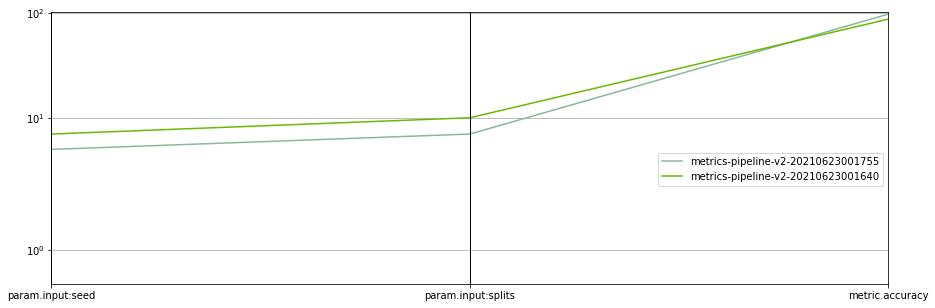

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = [15, 5]

pipeline_df["param.input:seed"] = pipeline_df["param.input:seed"].astype(np.float16)
pipeline_df["param.input:splits"] = pipeline_df["param.input:splits"].astype(np.float16)

ax = pd.plotting.parallel_coordinates(
    pipeline_df.reset_index(level=0),
    "run_name",
    cols=["param.input:seed", "param.input:splits", "metric.accuracy"],
    # color=['blue', 'green', 'pink', 'red'],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

### Plot ROC curve and calculate AUC number

In addition to basic metrics, you can extract complex metrics and perform further analysis using the `get_pipeline_df` method.

In [33]:
pipeline_df = aiplatform.get_pipeline_df(pipeline="metrics-pipeline-v2")
pipeline_df

,pipeline_name,run_name,param.input:splits,param.input:seed,metric.confusionMatrix,metric.accuracy,metric.confidenceMetrics
0,metrics-pipeline-v2,metrics-pipeline-v2-20210623001755,7,5,{'annotationSpecs': [{'displayName': 'Setosa'}...,96.666667,"[{'confidenceThreshold': 2.0, 'falsePositiveRa..."
1,metrics-pipeline-v2,metrics-pipeline-v2-20210623001640,10,7,"{'rows': [{'row': [19.0, 10.0, 0.0]}, {'row': ...",86.666667,"[{'confidenceThreshold': 2.0, 'falsePositiveRa..."


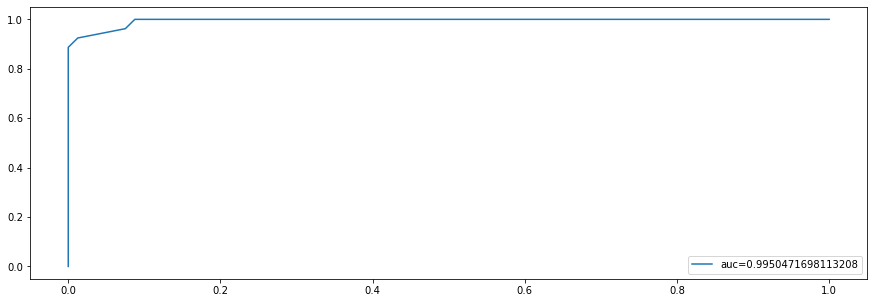

In [34]:
df = pd.DataFrame(pipeline_df["metric.confidenceMetrics"][0])
auc = np.trapz(df["recall"], df["falsePositiveRate"])
plt.plot(df["falsePositiveRate"], df["recall"], label="auc=" + str(auc))
plt.legend(loc=4)
plt.show()

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:
- delete Cloud Storage objects that were created.  Uncomment and run the command in the cell below **only if you are not using the `PIPELINE_ROOT` path for any other purpose**.


In [ ]:
# Warning: this command will delete ALL Cloud Storage objects under the PIPELINE_ROOT path.
# ! gsutil -m rm -r $PIPELINE_ROOT